## Chatper 4 분류

### 4. 랜덤 포레스트

#### 랜덤 포레스트의 개요 및 실습
랜덤 포레스트는 배깅(bagging)의 대표적인 알고리즘으로 속도도 빠르고 예측 성농도 좋다. 기반 알고리즘은 결정 트리로써 결정 트리의 쉽고 직관적인 장점을 그래도 가지고 있다.
랜덤 포레스트는 여러 개의 결정 트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 개별적으로 학습한 뒤 모든 분류기가 보팅을 통해 예측 결정을 하게 된다.
랜덤 포레스트는 개별적인 분류기의 기반 알고리즘은 결정 트리이지만, 개별 트리가 학습하는 데이터 세트는 전체 데이터 세트에서 일부가 중첩되게 샘플링된 데이터 세트이다. 이렇게 여러 데이터가 중첩되게 분리하는 것을 부트스트래핑(bootstrapping) 분할 방식이라고 한다. 랜덤 포레스트의 서브 세트 데이터의 수는 전체 데이터 세트의 수와 같지만 개별 데이터가 중첩되어 만들어진다.

In [1]:
# 랜덤 포레스트 실습을 위한 데이터셋 불러오기
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./data/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도 : 0.9253


#### 랜덤 포레스트 하이퍼 파라미터 및 튜닝

일반적으로 트리 기반의 앙상블 알고리즘의 단점은 하이퍼 파라미터가 너무 많고, 그로 인해 튜닝을 위한 시간이 많이 소요된다는 점이다. 그럼에도 불구하고 예측 성능이 크게 좋아지는 경우는 많지 않다.
그나마 랜덤 포레스트는 적은 편에 속하며 결정 트리에서 사용하는 하이퍼 파라미터와 같은 파라미터가 대부분이다.

- n_estimators : 결정 트리의 개수를 지정, 디폴트는 10이며 많이 설정할수록 좋은 성능 기대 가능 vut 항상 향상은 아니며 학습 수행 시간도 늘어남
- max_features : 결정 트리의 max_features와 같다. 기본값은 'auto', 즉, 'sqrt'와 같다. 따라서 랜덤 포레스트의 트리를 분할하는 피처를 참조할 때 sqrt(전체 피처 개수)만큼만 참조
- max_depth나 min_smaples_leaf와 같은 결정 트리에서 과적합 개선을 위한 파라미터도 똑같이 사용 가능

In [3]:
# GridSearchCV를 이용해 최적의 하이퍼 파라미터를 찾아보자.


from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [4]:
# n_estimators를 300으로 늘려 최적의 하이퍼 파라미터 조합과 RandomForestClassifier를 학습시킨 뒤
# 별도의 테스트 데이터 세트에서 예측 성능을 측정해보자.

rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, \
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.9165


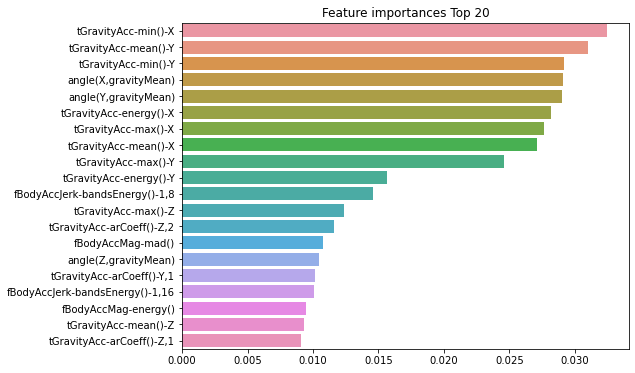

In [5]:
# RandomForestClassifier도 결정 트리와 같이 feature_importances_ 속성을 이용해 피처의 중요드를 알 수 있다.

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

### 5. GBM(Gradient Boosting Machine)

#### GBM의 개요 및 실습
부스팅 알고리즘은 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식이다.
대표적으로 AdaBoost와 그래디언트 부스트가 있다.
AdaBoost는 각 Step마다 잘못 예측한 데이터에 가중치를 부여하며 학습을 진행해 나가며 GBM과의 차이점은 GBM은 가중치 업데이트를 경사 하강버을 이용하는 것이 큰 차이이다. 오류 값은 실제 값 - 예측으로 계산한다.
GBM은 회귀도 가능하다.

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

GBM 정확도: 0.9389
GBM 수행 시간: 921.6 초 


일반적으로는 랜덤 포레스트보다 성능이 뛰어난 경우가 많다. 그러나 수행 시간이 오래 걸리며 하이퍼 파라미터 튜닝 노력도 필요하다.

#### GBM 하이퍼 파라미터 및 튜닝

n_estimators, max_depth, max_features와 같은 트리 기반 자체의 파라미터는 앞에서 나왔으니 생략

- loss : 경사 하강법에서 사용할 비용 함수 지정. 기본값은 'deviance'
- learning_rate : 학습률이며 0~1 값 지정 가능하다. 0.1이 기본값이다. 학습률의 특성 상 n_estimators와 상호 보완적으로 조합해 사용한다. (학습률 작게, n_estimators 크게 but 시간 오래걸림)
- n_estimators : weak learner의 개수이며 기본값은 100이다.
- subsample : weak learner가 사용하는 데이터의 샘플링 비율. 기본 값은 1이며 이는 전체 학습 데이터를 기반으로 학습한다는 의미이다. 과적합이 염려되면 1보다 작게 설정하자.

In [7]:
# 하이퍼 파라미터 튜닝

from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 145.6min finished


최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 500}
최고 예측 정확도: 0.9011


In [8]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.9420


### 6. XGBoost(eXtra Gradient Boost)

#### XGBoost 개요

XGBoost는 압도적 수치 차이는 아니지만 일반적으로 다른 머신러닝보다 뛰어난 성능을 보인다. GBM에 기반하고 있지만 느린 수행 시간을 해결했으며 (병렬 CPU 작업 가능 하지만 다른 알고리즘에 비해서는 빠르진 않다.) 과적합 규제 부재 등의 문제를 해결했다.
독자적 프레임워크 기반의 XGBoost를 파이썬 래퍼 XGBoost 모듈, 사이킷런과 연동되는 모듈을 사이킷런 래퍼 XGBoost 모듈이라고 지칭하자.

#### 파이썬 래퍼 XGBoost 하이퍼 파라미터

파이썬 래퍼 XGBoost 하이퍼 파라미터를 유형별로 나누면 다음과 같다.
- 일반 파라미터 : 일반적으로 실행 시 디폴트 파라미터 값을 바꾸는 일이 거의 없음
- 부스트 파라미터 : 트리 최적화, 부스팅, regularization 등과 관련 파라미터 등을 지칭한다.
- 학습 태스크 파라미터 ; 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정한다.

##### 주요 일반 파라미터
- booster : gbtree 또는 gblinear 선택. 디폴트는 gbtree
- silent : 디폴트는 0이며 출력 메시지를 나타내고 싶지 않으면 1로 지정
- nthread : 스레드 개수 조절 디폴트는 전체 스레드 모두 사용

##### 주요 부스터 파라미터
- eta : GBM의 학습률과 같은 파라미터. 0과 1 사이의 값을 지정. 디폴트는 0.3이다. 보통은 0.01 ~ 0.2 값 선호. 사이킷런 래퍼 XGBoost에서는 learning_rate로 대체
- num_boost_rounds : GBM의 n_estimators와 같음
- min_child_weight : 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 데이터들의 weight 총합. 클수록 분할을 자제한다. 디폴트는 1, 과적합 조절을 위해 사용한다.
- gamma : 트리의 리프 노드를 추가적으로 나눌지를 결정ㅎ알 최소 손실 감소 값. 해당 값보다 큰 손실이 감소된 경우 분리. 값이 클수록 가적합 감소 효과, 디폴트는 0 사이킷런 래퍼 클래스를 이용할 경우 min_split_loss로 대체
- max_depth : 디폴트는 6이다. 보통은 3-10 사이 값 사용
- sub_sample : GBM의 subsample과 동일 디폴트는 1이다. 일반적으로 0.5~1 사이 값 사용
- colsample_bytree : GBM의 max_features와 유사. 디폴트는 1이다. 트리 생성에 필요한 피처를 임의로 샘플링하는데 사용 과적합 제어 
- lambda : L2 Regulation 적용 값, 디폴트는 1 사이킷런 연동에서는 reg_lambda로 대체
- alpha : L1 Regulation 적용 값, 디폴트는 0, reg_alpha로 대체
- scale_pos_weight : 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파리미터로 디폴트는 1이다.

##### 학습 태스크 파라미터
- objective : 최솟값을 가져야 할 손실함수 정의
    - binary:logistic : 이진분류일 때 적용
    - multi:softmax : 다중 분류일 때 적용
    - multi:softprob : 개별 레이블 클래스의 해당되는 예측 확률 반환
- eval_metric : 검증에 사용되는 함수 정의. 기본값은 회귀일 경우 rmse, 분류일 경우 error
    - rmse : Root Mean Square Error
    - mae : Mean Absolute Error
    - logloss : Negative log-likelihood
    - error : Binary classification error rate (0.5 threshold)
    - merror : Multiclass classification error rate
    - mlogloss : Multiclass logloss
    - auc : Area under the curve
    
과적합이 심하다면?
- eta 값을 낮춘다. (num_round 또는 n_estimators는 반대로 높여야 한다.)
- max_depth 값을 낮춘다.
- min_child_weight 값으르 높인다.
- gamma 값을 높인다.
- subsample, colsample_bytree를 조정하는 것도 도움이 된다.

#### 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측

In [9]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [10]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [11]:

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )
print(X_train.shape , X_test.shape)

(455, 30) (114, 30)


In [12]:
# 학습용과 테스트용 데이터 세트를 위해 별도의 객체 DMatrix 생성 (주로 넘파이 입력 파라미터)
dtrain = xgb.DMatrix(data=X_train , label=y_train)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [13]:
params = { 'max_depth':3,
           'eta': 0.1,
           'objective':'binary:logistic',
           'eval_metric':'logloss'
        }
num_rounds = 400

In [14]:
# train 데이터 셋은 ‘train’ , evaluation(test) 데이터 셋은 ‘eval’ 로 명기합니다. 
wlist = [(dtrain,'train'),(dtest,'eval') ]

# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
# 조기중단을 위한 최소 반복 횟수 : early_stopping_rounds 파라미터
# evals에는 학습 데이터 세트와 eval 데이터 세트를 명기. 평가를 eval에 수행하며
# 조기중단 적용이 가능해짐
# train()은 학습이 완료된 모델 객체를 반환한다.
xgb_model = xgb.train(params = params , dtrain=dtrain , num_boost_round=num_rounds , \
                      early_stopping_rounds=100, evals=wlist )

[0]	train-logloss:0.609688	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540803	eval-logloss:0.547842
[2]	train-logloss:0.483753	eval-logloss:0.494247
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354145	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292592	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207937	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logl

[161]	train-logloss:0.007261	eval-logloss:0.088013
[162]	train-logloss:0.007241	eval-logloss:0.087758
[163]	train-logloss:0.007221	eval-logloss:0.087784
[164]	train-logloss:0.0072	eval-logloss:0.087777
[165]	train-logloss:0.00718	eval-logloss:0.087517
[166]	train-logloss:0.007161	eval-logloss:0.087542
[167]	train-logloss:0.007142	eval-logloss:0.087642
[168]	train-logloss:0.007122	eval-logloss:0.08739
[169]	train-logloss:0.007103	eval-logloss:0.087377
[170]	train-logloss:0.007084	eval-logloss:0.087298
[171]	train-logloss:0.007065	eval-logloss:0.087368
[172]	train-logloss:0.007047	eval-logloss:0.087395
[173]	train-logloss:0.007028	eval-logloss:0.087385
[174]	train-logloss:0.007009	eval-logloss:0.087132
[175]	train-logloss:0.006991	eval-logloss:0.087159
[176]	train-logloss:0.006973	eval-logloss:0.086955
[177]	train-logloss:0.006955	eval-logloss:0.087053
[178]	train-logloss:0.006937	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.086973
[180]	train-logloss:0.006901	eval-log

In [15]:
# 예측
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [16]:
# chapter 3에서 사용한 평가 함수

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
    
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


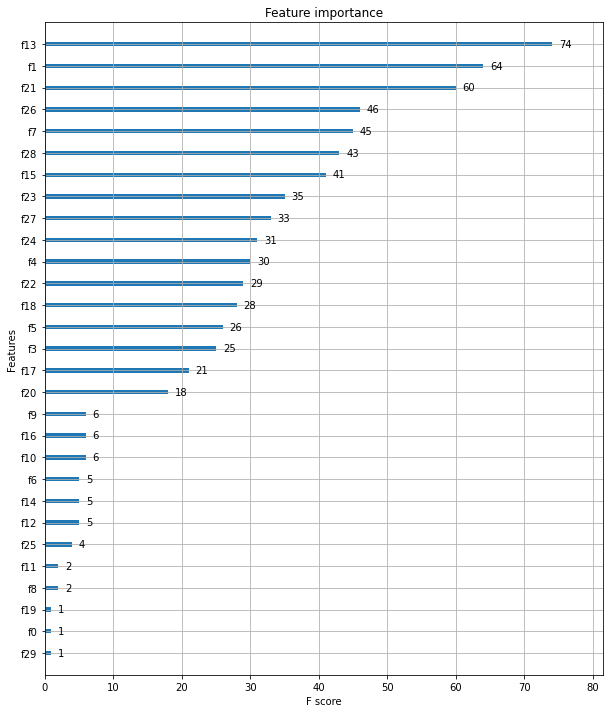

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# 피처 중요도 시각화
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

#### 사이킷런 래퍼 XGBoost의 개요 및 적용

XGBoost 개발 그룹은 사이킷런의 프레임워크와 연동하기 위해 전용 XGBoost 래퍼 클래스를 개발했다. fit, predict()와 GridSearchCV, pipeline 등 사이킷런의 다른 유틸리티를 그대로 사용 가능하다.
하이퍼 파라미터 몇 개는 다음과 같이 변경된다.
- eta => learning_rate
- sub_sample => subsample
- lambda => reg_lambda
- alpha => reg_alpha
또한, n_estimtors와 num_boost_round 하이퍼 파라미터는 서로 동일한 파라미터다.

In [18]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [19]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [20]:
# 조기 중단도 수행 가능하다.

# early_stopping_rounds를 10으로 설정하고 재 학습. 
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, 
                eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


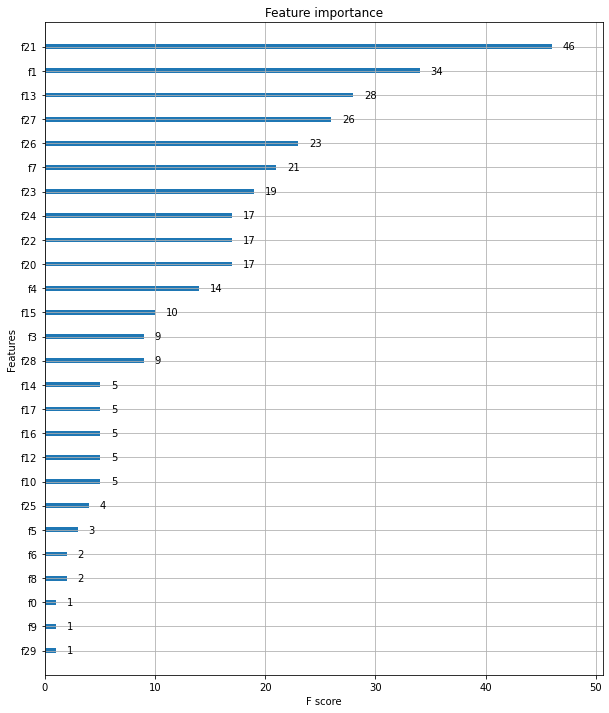

In [21]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)

### 7. LightGBM

LightGBM의 가장 큰 장점은 XGBoost보다 학습에 걸리는 시간이 적다는 점이다. 예측 성능 또한 비슷하며 기능상의 다양성은 약간 더 많다. 단점은 적은 데이터 세트에서 과적합이 발생하기 쉽다는 점이다. (10000건 이하)

![leafwise](./images/leafwise.png)

LightGBM은 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할 방식을 이용한다. 트리의 균형을 맞추지 않고, 최대 손실 값을 가지는 리프 노드를 지속적으로 분할하며 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성된다.
한편, LightGBM의 XGBoost 대바 장점은 다음과 같다. 
- 더 빠른 학습과 예측 수행 시간
- 더 작은 메모리 사용량
- 카테고리형 피처의 자동 변환과 최적 분할

#### LightGBM 하이퍼 파라미터

XGBoost와 많은 부분이 유사하지만, 리프 노드가 다르게 분할되면서 트리의 깊이가 깊어지므로 이러한 트리 특성에 맞는 하이퍼 파라미터 설정이 필요하다.

- num_iterations : 반복 수행하려는 트리의 개수 지정, 디폴트는 100이다. 크게 지정할수록 성능이 높아질 수 있지만 과적합 가능성 사이킷런 호환 클래스에서는 n_estimators로 사용
- learning_rate : 학습률, 디폴트는 0.1, 0~1값 사용
- max_depth : 디폴트는 -1로, 0보다 작은 값 사용시 깊이에 제한이 없다. LightGBM은 Leafwise이기에 깊이가 상대적으로 더 깊다.
- min_data_in_leaf : 결정 트리의 min_samples_leaf와 같다. 디폴트는 20. 사이킷런 호환 클래스에서는 min_child_samples로 사용
- num_leaves : 하나의 트리가 가질 수 있는 최대 리프 개수, 디폴트는 31
- boosting : 부스팅의 트리를 생성하는 알고리즘 기술, 디폴트는 gbdt
    - gbdt : 일반적은 그래디언트 부스팅 결정 트리
    - rf : 랜덤 포레스트
- bagging_fraction : 트리가 커져서 과적합되는 것을 제어하기 위해서 세이터를 샘플링하는 비율을 지정한다. 사이킷런 호환 클래스에서는 subsample로 사용
- feature_fraction : 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율, 과적합을 막기 위해 사용, 디폴트는 1.0 GBM의 max_features와 유사, 사이킷런 호환 클랫에서는 colsample_bytree로 변경
- lambda_l2 : 디폴트는 0.0, l2규제를 위한 값
- lambda_l1 : 디폴트는 0.0, l1규제를 위한 값
- objective : 최솟값을 가져야 할 손실함수 정의, XGBoost의 objective 파라미터와 동일

#### 하이퍼 파라미터 튜닝 방안

num_leaves의 개수를 중심으로 min_child_samples, max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안이다.

- num_leaves는 개별 트리가 가질 수 있는 최대 리프 개수이고 모델 복잡도를 제어하는 주요 파라이터이다. 개수가 크면 정확도가 높아지지만 과적합 영향도가 커진다.
- min_data_in_leaf는 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지한다.
- max_depth는 명시적으로 깊이의 크기를 제한한다.

학습률을 작게하면서 n_estimators를 크게 하는 것은 가장 기본적인 튜닝 방안이므로 이를 적용하는 것도 좋다. 이 외에도 다른 방법들을 적용할 수도 있다.

In [1]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(ftr, target, test_size=0.2, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정. 
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능. 
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_loglo

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 평가 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

# 평가
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870,    F1: 0.9682, AUC:0.9905


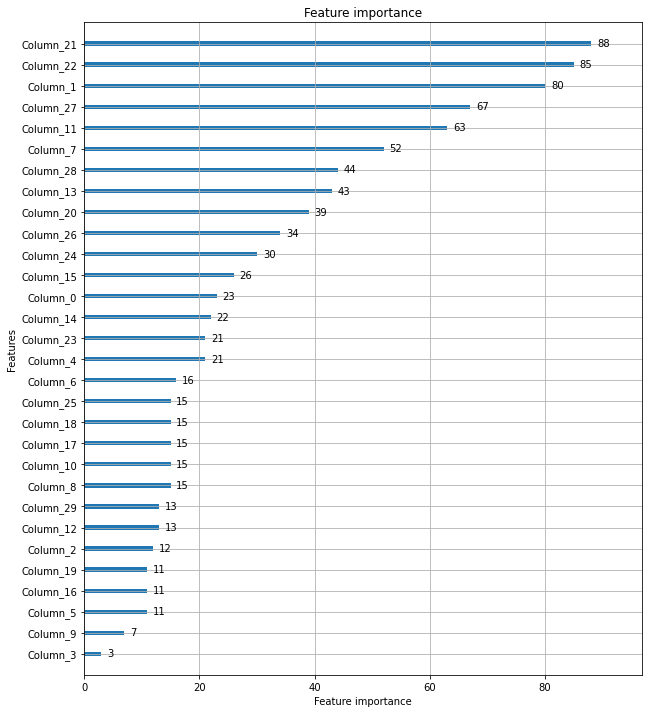

In [3]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)

### 8. 분류 실습 - 캐글 산탄데르 고객 만족 예측

In [1]:
# 데이터 전처리

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("./data/train_santander.csv",encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [2]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [3]:
# target 불균형

print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [4]:
cust_df.describe( )

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [5]:
# ID는 단순 식별자에 불과하므로 드롭
# var3의 -99999는 아마 널값 같은 것을 대체했을 것, 가장 값이 많은 2로 변환하자.

# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999,2, inplace=True)
cust_df.drop('ID',axis=1 , inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

[142]	validation_0-auc:0.861553	validation_1-auc:0.841335
[143]	validation_0-auc:0.861682	validation_1-auc:0.841346
[144]	validation_0-auc:0.86169	validation_1-auc:0.841403
[145]	validation_0-auc:0.861852	validation_1-auc:0.841299
[146]	validation_0-auc:0.861898	validation_1-auc:0.841301
[147]	validation_0-auc:0.861998	validation_1-auc:0.841289
[148]	validation_0-auc:0.862068	validation_1-auc:0.84135
[149]	validation_0-auc:0.862132	validation_1-auc:0.841444
[150]	validation_0-auc:0.862236	validation_1-auc:0.841409
[151]	validation_0-auc:0.862314	validation_1-auc:0.841459
[152]	validation_0-auc:0.862584	validation_1-auc:0.841456
[153]	validation_0-auc:0.862843	validation_1-auc:0.841483
[154]	validation_0-auc:0.863033	validation_1-auc:0.841493
[155]	validation_0-auc:0.863132	validation_1-auc:0.841534
[156]	validation_0-auc:0.863423	validation_1-auc:0.841728
[157]	validation_0-auc:0.863578	validation_1-auc:0.841712
[158]	validation_0-auc:0.863872	validation_1-auc:0.841677
[159]	validation

In [8]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5, 7] , 'min_child_weight':[1,3] ,'colsample_bytree':[0.5, 0.75] }

# cv는 3으로 지정 
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_) 

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.715421	validation_1-auc:0.722463
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.802772	validation_1-auc:0.807648
[2]	validation_0-auc:0.800147	validation_1-auc:0.804566
[3]	validation_0-auc:0.805692	validation_1-auc:0.809325
[4]	validation_0-auc:0.814807	validation_1-auc:0.816951
[5]	validation_0-auc:0.810346	validation_1-auc:0.812634
[6]	validation_0-auc:0.810623	validation_1-auc:0.814491
[7]	validation_0-auc:0.818556	validation_1-auc:0.820561
[8]	validation_0-auc:0.822006	validation_1-auc:0.823553
[9]	validation_0-auc:0.820433	validation_1-auc:0.821292
[10]	validation_0-auc:0.826212	validation_1-auc:0.825279
[11]	validation_0-auc:0.830077	validation_1-auc:0.827817
[12]	validation_0-auc:0.832328	validation_1-auc:0.828775
[13]	validation_0-auc:0.832008	validation_1-auc:0.827865
[14]	validation_0-auc:0.830319	validation_1-auc:0.82674

[51]	validation_0-auc:0.86387	validation_1-auc:0.843007
[52]	validation_0-auc:0.864428	validation_1-auc:0.843608
[53]	validation_0-auc:0.86492	validation_1-auc:0.843887
[54]	validation_0-auc:0.865341	validation_1-auc:0.844128
[55]	validation_0-auc:0.865713	validation_1-auc:0.843955
[56]	validation_0-auc:0.866165	validation_1-auc:0.844301
[57]	validation_0-auc:0.866538	validation_1-auc:0.84439
[58]	validation_0-auc:0.86671	validation_1-auc:0.844055
[59]	validation_0-auc:0.866977	validation_1-auc:0.843974
[60]	validation_0-auc:0.867483	validation_1-auc:0.8439
[61]	validation_0-auc:0.867853	validation_1-auc:0.843561
[62]	validation_0-auc:0.86811	validation_1-auc:0.843594
[63]	validation_0-auc:0.868319	validation_1-auc:0.843498
[64]	validation_0-auc:0.868554	validation_1-auc:0.843615
[65]	validation_0-auc:0.869021	validation_1-auc:0.843756
[66]	validation_0-auc:0.869095	validation_1-auc:0.843781
[67]	validation_0-auc:0.869277	validation_1-auc:0.843635
[68]	validation_0-auc:0.869639	validat

[1]	validation_0-auc:0.804027	validation_1-auc:0.809028
[2]	validation_0-auc:0.796929	validation_1-auc:0.805684
[3]	validation_0-auc:0.80379	validation_1-auc:0.811591
[4]	validation_0-auc:0.811904	validation_1-auc:0.818375
[5]	validation_0-auc:0.808826	validation_1-auc:0.815714
[6]	validation_0-auc:0.809236	validation_1-auc:0.816054
[7]	validation_0-auc:0.818354	validation_1-auc:0.823376
[8]	validation_0-auc:0.822085	validation_1-auc:0.826164
[9]	validation_0-auc:0.82165	validation_1-auc:0.824633
[10]	validation_0-auc:0.825876	validation_1-auc:0.828152
[11]	validation_0-auc:0.830307	validation_1-auc:0.830536
[12]	validation_0-auc:0.832494	validation_1-auc:0.831414
[13]	validation_0-auc:0.832283	validation_1-auc:0.831058
[14]	validation_0-auc:0.830152	validation_1-auc:0.829388
[15]	validation_0-auc:0.833723	validation_1-auc:0.831545
[16]	validation_0-auc:0.835902	validation_1-auc:0.833087
[17]	validation_0-auc:0.838024	validation_1-auc:0.835309
[18]	validation_0-auc:0.840344	validation_

[57]	validation_0-auc:0.863066	validation_1-auc:0.845717
[58]	validation_0-auc:0.863413	validation_1-auc:0.845678
[59]	validation_0-auc:0.863608	validation_1-auc:0.84581
[60]	validation_0-auc:0.86412	validation_1-auc:0.845891
[61]	validation_0-auc:0.864399	validation_1-auc:0.845775
[62]	validation_0-auc:0.864521	validation_1-auc:0.845851
[63]	validation_0-auc:0.864786	validation_1-auc:0.845721
[64]	validation_0-auc:0.865062	validation_1-auc:0.845821
[65]	validation_0-auc:0.865567	validation_1-auc:0.845831
[66]	validation_0-auc:0.865616	validation_1-auc:0.845926
[67]	validation_0-auc:0.865942	validation_1-auc:0.845591
[68]	validation_0-auc:0.866071	validation_1-auc:0.845562
[69]	validation_0-auc:0.866158	validation_1-auc:0.845375
[70]	validation_0-auc:0.866421	validation_1-auc:0.845291
[71]	validation_0-auc:0.866631	validation_1-auc:0.845063
[72]	validation_0-auc:0.866834	validation_1-auc:0.844927
[73]	validation_0-auc:0.867035	validation_1-auc:0.844978
[74]	validation_0-auc:0.867128	va

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.809965	validation_1-auc:0.808886
[2]	validation_0-auc:0.804423	validation_1-auc:0.807373
[3]	validation_0-auc:0.815189	validation_1-auc:0.816603
[4]	validation_0-auc:0.824234	validation_1-auc:0.823278
[5]	validation_0-auc:0.819568	validation_1-auc:0.81934
[6]	validation_0-auc:0.819199	validation_1-auc:0.818772
[7]	validation_0-auc:0.827364	validation_1-auc:0.826183
[8]	validation_0-auc:0.831947	validation_1-auc:0.829293
[9]	validation_0-auc:0.832248	validation_1-auc:0.827116
[10]	validation_0-auc:0.836511	validation_1-auc:0.829685
[11]	validation_0-auc:0.841032	validation_1-auc:0.831312
[12]	validation_0-auc:0.843673	validation_1-auc:0.831989
[13]	validation_0-auc:0.843697	validation_1-auc:0.832132
[14]	validation_0-auc:0.843356	validation_1-auc:0.830392
[15]	validation_0-auc:0.846759	validation_1-auc:0.83237

[77]	validation_0-auc:0.892957	validation_1-auc:0.844356
[78]	validation_0-auc:0.893228	validation_1-auc:0.84433
[79]	validation_0-auc:0.893375	validation_1-auc:0.844108
[80]	validation_0-auc:0.893476	validation_1-auc:0.844037
[81]	validation_0-auc:0.893656	validation_1-auc:0.844067
[82]	validation_0-auc:0.893838	validation_1-auc:0.843845
[83]	validation_0-auc:0.894993	validation_1-auc:0.84388
[84]	validation_0-auc:0.895174	validation_1-auc:0.843781
[85]	validation_0-auc:0.895171	validation_1-auc:0.844018
[86]	validation_0-auc:0.895293	validation_1-auc:0.843721
[87]	validation_0-auc:0.895377	validation_1-auc:0.843689
[88]	validation_0-auc:0.895614	validation_1-auc:0.8435
[89]	validation_0-auc:0.895597	validation_1-auc:0.84341
[90]	validation_0-auc:0.896023	validation_1-auc:0.843738
[91]	validation_0-auc:0.896194	validation_1-auc:0.843675
[92]	validation_0-auc:0.896304	validation_1-auc:0.843666
[93]	validation_0-auc:0.896388	validation_1-auc:0.8436
[94]	validation_0-auc:0.89645	validati

[17]	validation_0-auc:0.85058	validation_1-auc:0.835537
[18]	validation_0-auc:0.852488	validation_1-auc:0.836913
[19]	validation_0-auc:0.851413	validation_1-auc:0.83678
[20]	validation_0-auc:0.853824	validation_1-auc:0.837786
[21]	validation_0-auc:0.853711	validation_1-auc:0.836986
[22]	validation_0-auc:0.852989	validation_1-auc:0.835059
[23]	validation_0-auc:0.855112	validation_1-auc:0.836803
[24]	validation_0-auc:0.856859	validation_1-auc:0.838802
[25]	validation_0-auc:0.85723	validation_1-auc:0.83782
[26]	validation_0-auc:0.857535	validation_1-auc:0.836375
[27]	validation_0-auc:0.85929	validation_1-auc:0.837784
[28]	validation_0-auc:0.860972	validation_1-auc:0.837979
[29]	validation_0-auc:0.860682	validation_1-auc:0.837827
[30]	validation_0-auc:0.862143	validation_1-auc:0.838806
[31]	validation_0-auc:0.863184	validation_1-auc:0.839024
[32]	validation_0-auc:0.863638	validation_1-auc:0.838132
[33]	validation_0-auc:0.864268	validation_1-auc:0.838288
[34]	validation_0-auc:0.8644	validat

Stopping. Best iteration:
[65]	validation_0-auc:0.882333	validation_1-auc:0.843298

[0]	validation_0-auc:0.740963	validation_1-auc:0.745305
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.82294	validation_1-auc:0.821542
[2]	validation_0-auc:0.813813	validation_1-auc:0.809933
[3]	validation_0-auc:0.827473	validation_1-auc:0.822227
[4]	validation_0-auc:0.832393	validation_1-auc:0.826685
[5]	validation_0-auc:0.831888	validation_1-auc:0.822684
[6]	validation_0-auc:0.831945	validation_1-auc:0.821011
[7]	validation_0-auc:0.835043	validation_1-auc:0.824823
[8]	validation_0-auc:0.839917	validation_1-auc:0.82833
[9]	validation_0-auc:0.839675	validation_1-auc:0.827635
[10]	validation_0-auc:0.843606	validation_1-auc:0.829718
[11]	validation_0-auc:0.846078	validation_1-auc:0.833888
[12]	validation_0-auc:0.848075	validation_1-auc:0.834836
[13]	validation_0-auc:0.849433

[45]	validation_0-auc:0.860625	validation_1-auc:0.839082
[46]	validation_0-auc:0.860953	validation_1-auc:0.839125
[47]	validation_0-auc:0.861608	validation_1-auc:0.838995
[48]	validation_0-auc:0.862085	validation_1-auc:0.839059
[49]	validation_0-auc:0.862354	validation_1-auc:0.839387
[50]	validation_0-auc:0.862812	validation_1-auc:0.839298
[51]	validation_0-auc:0.863372	validation_1-auc:0.839127
[52]	validation_0-auc:0.864029	validation_1-auc:0.839097
[53]	validation_0-auc:0.864379	validation_1-auc:0.839118
[54]	validation_0-auc:0.864775	validation_1-auc:0.838848
[55]	validation_0-auc:0.86518	validation_1-auc:0.838897
[56]	validation_0-auc:0.865428	validation_1-auc:0.838671
[57]	validation_0-auc:0.865679	validation_1-auc:0.838451
[58]	validation_0-auc:0.866057	validation_1-auc:0.838382
[59]	validation_0-auc:0.866205	validation_1-auc:0.838363
[60]	validation_0-auc:0.866485	validation_1-auc:0.83804
[61]	validation_0-auc:0.866681	validation_1-auc:0.837604
[62]	validation_0-auc:0.867	valid

[17]	validation_0-auc:0.844972	validation_1-auc:0.836283
[18]	validation_0-auc:0.845411	validation_1-auc:0.836243
[19]	validation_0-auc:0.845623	validation_1-auc:0.837443
[20]	validation_0-auc:0.846563	validation_1-auc:0.837309
[21]	validation_0-auc:0.846794	validation_1-auc:0.837453
[22]	validation_0-auc:0.847843	validation_1-auc:0.837781
[23]	validation_0-auc:0.848615	validation_1-auc:0.838383
[24]	validation_0-auc:0.849434	validation_1-auc:0.838103
[25]	validation_0-auc:0.85036	validation_1-auc:0.838932
[26]	validation_0-auc:0.850801	validation_1-auc:0.838703
[27]	validation_0-auc:0.850936	validation_1-auc:0.837935
[28]	validation_0-auc:0.851557	validation_1-auc:0.837842
[29]	validation_0-auc:0.852139	validation_1-auc:0.837859
[30]	validation_0-auc:0.852693	validation_1-auc:0.8387
[31]	validation_0-auc:0.853579	validation_1-auc:0.838874
[32]	validation_0-auc:0.853998	validation_1-auc:0.838908
[33]	validation_0-auc:0.85455	validation_1-auc:0.839699
[34]	validation_0-auc:0.855415	vali

[59]	validation_0-auc:0.862575	validation_1-auc:0.839266
[60]	validation_0-auc:0.862755	validation_1-auc:0.839195
[61]	validation_0-auc:0.86307	validation_1-auc:0.839449
[62]	validation_0-auc:0.863241	validation_1-auc:0.839404
[63]	validation_0-auc:0.863658	validation_1-auc:0.839428
[64]	validation_0-auc:0.86375	validation_1-auc:0.839621
[65]	validation_0-auc:0.86421	validation_1-auc:0.839633
[66]	validation_0-auc:0.86447	validation_1-auc:0.839787
[67]	validation_0-auc:0.86483	validation_1-auc:0.839489
[68]	validation_0-auc:0.864976	validation_1-auc:0.839477
[69]	validation_0-auc:0.865145	validation_1-auc:0.83945
Stopping. Best iteration:
[39]	validation_0-auc:0.855169	validation_1-auc:0.840194

[0]	validation_0-auc:0.811089	validation_1-auc:0.810522
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.816087	validation_1-auc:0.810073
[2]	validation_0-auc:0.822

[27]	validation_0-auc:0.85049	validation_1-auc:0.838129
[28]	validation_0-auc:0.850674	validation_1-auc:0.837812
[29]	validation_0-auc:0.851227	validation_1-auc:0.838234
[30]	validation_0-auc:0.851623	validation_1-auc:0.838185
[31]	validation_0-auc:0.852504	validation_1-auc:0.838433
[32]	validation_0-auc:0.853015	validation_1-auc:0.838103
[33]	validation_0-auc:0.8536	validation_1-auc:0.838398
[34]	validation_0-auc:0.854335	validation_1-auc:0.838896
[35]	validation_0-auc:0.854663	validation_1-auc:0.839009
[36]	validation_0-auc:0.855138	validation_1-auc:0.839035
[37]	validation_0-auc:0.855351	validation_1-auc:0.839193
[38]	validation_0-auc:0.856105	validation_1-auc:0.839668
[39]	validation_0-auc:0.856527	validation_1-auc:0.83972
[40]	validation_0-auc:0.857019	validation_1-auc:0.840403
[41]	validation_0-auc:0.8577	validation_1-auc:0.840506
[42]	validation_0-auc:0.85823	validation_1-auc:0.840863
[43]	validation_0-auc:0.858341	validation_1-auc:0.840702
[44]	validation_0-auc:0.858849	validat

[4]	validation_0-auc:0.83547	validation_1-auc:0.826685
[5]	validation_0-auc:0.840865	validation_1-auc:0.832065
[6]	validation_0-auc:0.843256	validation_1-auc:0.831047
[7]	validation_0-auc:0.844488	validation_1-auc:0.82997
[8]	validation_0-auc:0.846035	validation_1-auc:0.83064
[9]	validation_0-auc:0.847946	validation_1-auc:0.831142
[10]	validation_0-auc:0.848745	validation_1-auc:0.831627
[11]	validation_0-auc:0.850347	validation_1-auc:0.832598
[12]	validation_0-auc:0.851272	validation_1-auc:0.832519
[13]	validation_0-auc:0.853669	validation_1-auc:0.834865
[14]	validation_0-auc:0.855251	validation_1-auc:0.835849
[15]	validation_0-auc:0.856435	validation_1-auc:0.83605
[16]	validation_0-auc:0.857587	validation_1-auc:0.836177
[17]	validation_0-auc:0.859351	validation_1-auc:0.836231
[18]	validation_0-auc:0.860285	validation_1-auc:0.836331
[19]	validation_0-auc:0.860357	validation_1-auc:0.837599
[20]	validation_0-auc:0.862392	validation_1-auc:0.83764
[21]	validation_0-auc:0.862808	validation_

[63]	validation_0-auc:0.89141	validation_1-auc:0.841085
[64]	validation_0-auc:0.891682	validation_1-auc:0.841143
[65]	validation_0-auc:0.892278	validation_1-auc:0.841065
[66]	validation_0-auc:0.892727	validation_1-auc:0.840958
[67]	validation_0-auc:0.893137	validation_1-auc:0.840921
[68]	validation_0-auc:0.893388	validation_1-auc:0.840771
[69]	validation_0-auc:0.893529	validation_1-auc:0.84087
[70]	validation_0-auc:0.893802	validation_1-auc:0.840709
[71]	validation_0-auc:0.893855	validation_1-auc:0.840794
[72]	validation_0-auc:0.894019	validation_1-auc:0.840836
[73]	validation_0-auc:0.894373	validation_1-auc:0.841008
[74]	validation_0-auc:0.894542	validation_1-auc:0.840932
[75]	validation_0-auc:0.894724	validation_1-auc:0.840937
Stopping. Best iteration:
[45]	validation_0-auc:0.884335	validation_1-auc:0.842062

[0]	validation_0-auc:0.816109	validation_1-auc:0.811
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-a

[59]	validation_0-auc:0.882357	validation_1-auc:0.841579
[60]	validation_0-auc:0.882716	validation_1-auc:0.841512
[61]	validation_0-auc:0.882939	validation_1-auc:0.841415
[62]	validation_0-auc:0.883049	validation_1-auc:0.841426
[63]	validation_0-auc:0.883365	validation_1-auc:0.841612
[64]	validation_0-auc:0.883681	validation_1-auc:0.841852
[65]	validation_0-auc:0.884057	validation_1-auc:0.841847
[66]	validation_0-auc:0.884053	validation_1-auc:0.841909
[67]	validation_0-auc:0.88446	validation_1-auc:0.841985
[68]	validation_0-auc:0.884938	validation_1-auc:0.841768
[69]	validation_0-auc:0.885009	validation_1-auc:0.841656
[70]	validation_0-auc:0.885288	validation_1-auc:0.841626
[71]	validation_0-auc:0.885498	validation_1-auc:0.841288
[72]	validation_0-auc:0.885587	validation_1-auc:0.841334
[73]	validation_0-auc:0.885921	validation_1-auc:0.841217
[74]	validation_0-auc:0.886022	validation_1-auc:0.841253
[75]	validation_0-auc:0.886104	validation_1-auc:0.841179
[76]	validation_0-auc:0.886118	v

[19]	validation_0-auc:0.846482	validation_1-auc:0.838554
[20]	validation_0-auc:0.848726	validation_1-auc:0.840214
[21]	validation_0-auc:0.847695	validation_1-auc:0.838583
[22]	validation_0-auc:0.84676	validation_1-auc:0.838167
[23]	validation_0-auc:0.848966	validation_1-auc:0.83963
[24]	validation_0-auc:0.850153	validation_1-auc:0.840161
[25]	validation_0-auc:0.850518	validation_1-auc:0.838865
[26]	validation_0-auc:0.850326	validation_1-auc:0.83861
[27]	validation_0-auc:0.851898	validation_1-auc:0.839714
[28]	validation_0-auc:0.853439	validation_1-auc:0.83974
[29]	validation_0-auc:0.853446	validation_1-auc:0.840649
[30]	validation_0-auc:0.854315	validation_1-auc:0.840818
[31]	validation_0-auc:0.855389	validation_1-auc:0.841412
[32]	validation_0-auc:0.855959	validation_1-auc:0.841502
[33]	validation_0-auc:0.856346	validation_1-auc:0.841478
[34]	validation_0-auc:0.856286	validation_1-auc:0.841234
[35]	validation_0-auc:0.857969	validation_1-auc:0.842276
[36]	validation_0-auc:0.859291	vali

XGBoostError: need to call fit or load_model beforehand

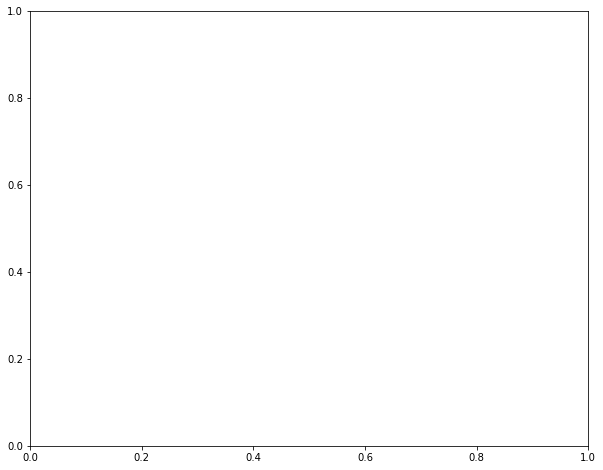

In [10]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

In [11]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.834093	valid_0's binary_logloss: 0.149427
[7]	valid_0's auc: 0.837046	valid_0's binary_logloss: 0.147961
[8]	valid_0's auc: 0.837838	valid_0's binary_logloss: 0.146591
[9]	valid_0's auc: 0.839435	valid_0's binary_logloss: 0.145455
[10]	valid_0's auc: 0.83973	valid_0's binary_logloss: 0.144486
[11]	valid_0's auc: 0.839799	valid_0's binary_logloss: 0.143769
[12]	valid_0's auc: 0.840034	valid_0's binary_logloss: 0.143146
[13]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.142533
[14]	valid_0's auc: 0.840342	valid_0's binary_logloss: 0.142036
[15]	valid_0's auc: 0.840928	valid_0's binary_loglos

In [12]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}


# cv는 3으로 지정 
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	val

[34]	valid_0's auc: 0.87774	valid_0's binary_logloss: 0.122892	valid_1's auc: 0.838376	valid_1's binary_logloss: 0.139342
[35]	valid_0's auc: 0.878372	valid_0's binary_logloss: 0.122634	valid_1's auc: 0.838454	valid_1's binary_logloss: 0.13931
[36]	valid_0's auc: 0.879098	valid_0's binary_logloss: 0.122414	valid_1's auc: 0.838895	valid_1's binary_logloss: 0.13925
[37]	valid_0's auc: 0.879502	valid_0's binary_logloss: 0.122216	valid_1's auc: 0.838441	valid_1's binary_logloss: 0.139302
[38]	valid_0's auc: 0.880036	valid_0's binary_logloss: 0.121998	valid_1's auc: 0.838582	valid_1's binary_logloss: 0.139306
[39]	valid_0's auc: 0.880641	valid_0's binary_logloss: 0.121716	valid_1's auc: 0.838787	valid_1's binary_logloss: 0.139269
[40]	valid_0's auc: 0.881249	valid_0's binary_logloss: 0.121482	valid_1's auc: 0.838906	valid_1's binary_logloss: 0.139223
[41]	valid_0's auc: 0.881919	valid_0's binary_logloss: 0.121223	valid_1's auc: 0.838567	valid_1's binary_logloss: 0.13926
Early stopping, best

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	val

[36]	valid_0's auc: 0.879098	valid_0's binary_logloss: 0.122414	valid_1's auc: 0.838895	valid_1's binary_logloss: 0.13925
[37]	valid_0's auc: 0.879502	valid_0's binary_logloss: 0.122216	valid_1's auc: 0.838441	valid_1's binary_logloss: 0.139302
[38]	valid_0's auc: 0.880036	valid_0's binary_logloss: 0.121998	valid_1's auc: 0.838582	valid_1's binary_logloss: 0.139306
[39]	valid_0's auc: 0.880641	valid_0's binary_logloss: 0.121716	valid_1's auc: 0.838787	valid_1's binary_logloss: 0.139269
[40]	valid_0's auc: 0.881249	valid_0's binary_logloss: 0.121482	valid_1's auc: 0.838906	valid_1's binary_logloss: 0.139223
[41]	valid_0's auc: 0.881919	valid_0's binary_logloss: 0.121223	valid_1's auc: 0.838567	valid_1's binary_logloss: 0.13926
Early stopping, best iteration is:
[11]	valid_0's auc: 0.855647	valid_0's binary_logloss: 0.133227	valid_1's auc: 0.840035	valid_1's binary_logloss: 0.143552
[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_log

[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	vali

[28]	valid_0's auc: 0.890552	valid_0's binary_logloss: 0.118602	valid_1's auc: 0.836524	valid_1's binary_logloss: 0.139871
[29]	valid_0's auc: 0.891402	valid_0's binary_logloss: 0.118166	valid_1's auc: 0.836264	valid_1's binary_logloss: 0.139884
[30]	valid_0's auc: 0.891982	valid_0's binary_logloss: 0.117805	valid_1's auc: 0.835959	valid_1's binary_logloss: 0.139937
[31]	valid_0's auc: 0.893185	valid_0's binary_logloss: 0.117392	valid_1's auc: 0.836384	valid_1's binary_logloss: 0.13992
[32]	valid_0's auc: 0.894065	valid_0's binary_logloss: 0.117017	valid_1's auc: 0.836341	valid_1's binary_logloss: 0.139888
[33]	valid_0's auc: 0.894791	valid_0's binary_logloss: 0.116671	valid_1's auc: 0.836753	valid_1's binary_logloss: 0.139812
[34]	valid_0's auc: 0.895313	valid_0's binary_logloss: 0.116321	valid_1's auc: 0.836733	valid_1's binary_logloss: 0.139826
[35]	valid_0's auc: 0.895876	valid_0's binary_logloss: 0.116039	valid_1's auc: 0.836245	valid_1's binary_logloss: 0.139883
[36]	valid_0's au

[54]	valid_0's auc: 0.905166	valid_0's binary_logloss: 0.110627	valid_1's auc: 0.83411	valid_1's binary_logloss: 0.141282
[55]	valid_0's auc: 0.905665	valid_0's binary_logloss: 0.110375	valid_1's auc: 0.833739	valid_1's binary_logloss: 0.141413
Early stopping, best iteration is:
[25]	valid_0's auc: 0.885234	valid_0's binary_logloss: 0.120268	valid_1's auc: 0.836722	valid_1's binary_logloss: 0.140403
[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss:

[28]	valid_0's auc: 0.890552	valid_0's binary_logloss: 0.118602	valid_1's auc: 0.836524	valid_1's binary_logloss: 0.139871
[29]	valid_0's auc: 0.891402	valid_0's binary_logloss: 0.118166	valid_1's auc: 0.836264	valid_1's binary_logloss: 0.139884
[30]	valid_0's auc: 0.891982	valid_0's binary_logloss: 0.117805	valid_1's auc: 0.835959	valid_1's binary_logloss: 0.139937
[31]	valid_0's auc: 0.893185	valid_0's binary_logloss: 0.117392	valid_1's auc: 0.836384	valid_1's binary_logloss: 0.13992
[32]	valid_0's auc: 0.894065	valid_0's binary_logloss: 0.117017	valid_1's auc: 0.836341	valid_1's binary_logloss: 0.139888
[33]	valid_0's auc: 0.894791	valid_0's binary_logloss: 0.116671	valid_1's auc: 0.836753	valid_1's binary_logloss: 0.139812
[34]	valid_0's auc: 0.895313	valid_0's binary_logloss: 0.116321	valid_1's auc: 0.836733	valid_1's binary_logloss: 0.139826
[35]	valid_0's auc: 0.895876	valid_0's binary_logloss: 0.116039	valid_1's auc: 0.836245	valid_1's binary_logloss: 0.139883
[36]	valid_0's au

[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	

[24]	valid_0's auc: 0.867054	valid_0's binary_logloss: 0.126749	valid_1's auc: 0.838187	valid_1's binary_logloss: 0.139526
[25]	valid_0's auc: 0.867553	valid_0's binary_logloss: 0.126476	valid_1's auc: 0.838308	valid_1's binary_logloss: 0.13949
[26]	valid_0's auc: 0.868108	valid_0's binary_logloss: 0.126164	valid_1's auc: 0.838035	valid_1's binary_logloss: 0.139426
[27]	valid_0's auc: 0.869014	valid_0's binary_logloss: 0.125868	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.139445
[28]	valid_0's auc: 0.869797	valid_0's binary_logloss: 0.12559	valid_1's auc: 0.837894	valid_1's binary_logloss: 0.139419
[29]	valid_0's auc: 0.870435	valid_0's binary_logloss: 0.1253	valid_1's auc: 0.838103	valid_1's binary_logloss: 0.139321
[30]	valid_0's auc: 0.87141	valid_0's binary_logloss: 0.125025	valid_1's auc: 0.838164	valid_1's binary_logloss: 0.139275
[31]	valid_0's auc: 0.872143	valid_0's binary_logloss: 0.124769	valid_1's auc: 0.837843	valid_1's binary_logloss: 0.139285
[32]	valid_0's auc: 0

[59]	valid_0's auc: 0.885965	valid_0's binary_logloss: 0.119403	valid_1's auc: 0.837558	valid_1's binary_logloss: 0.140007
[60]	valid_0's auc: 0.886208	valid_0's binary_logloss: 0.119263	valid_1's auc: 0.83744	valid_1's binary_logloss: 0.140079
[61]	valid_0's auc: 0.886458	valid_0's binary_logloss: 0.119118	valid_1's auc: 0.837349	valid_1's binary_logloss: 0.140059
Early stopping, best iteration is:
[31]	valid_0's auc: 0.87247	valid_0's binary_logloss: 0.124907	valid_1's auc: 0.838959	valid_1's binary_logloss: 0.139727
[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logl

[25]	valid_0's auc: 0.867553	valid_0's binary_logloss: 0.126476	valid_1's auc: 0.838308	valid_1's binary_logloss: 0.13949
[26]	valid_0's auc: 0.868108	valid_0's binary_logloss: 0.126164	valid_1's auc: 0.838035	valid_1's binary_logloss: 0.139426
[27]	valid_0's auc: 0.869014	valid_0's binary_logloss: 0.125868	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.139445
[28]	valid_0's auc: 0.869797	valid_0's binary_logloss: 0.12559	valid_1's auc: 0.837894	valid_1's binary_logloss: 0.139419
[29]	valid_0's auc: 0.870435	valid_0's binary_logloss: 0.1253	valid_1's auc: 0.838103	valid_1's binary_logloss: 0.139321
[30]	valid_0's auc: 0.87141	valid_0's binary_logloss: 0.125025	valid_1's auc: 0.838164	valid_1's binary_logloss: 0.139275
[31]	valid_0's auc: 0.872143	valid_0's binary_logloss: 0.124769	valid_1's auc: 0.837843	valid_1's binary_logloss: 0.139285
[32]	valid_0's auc: 0.872606	valid_0's binary_logloss: 0.124561	valid_1's auc: 0.837662	valid_1's binary_logloss: 0.139274
[33]	valid_0's auc: 0

[56]	valid_0's auc: 0.88511	valid_0's binary_logloss: 0.11989	valid_1's auc: 0.837646	valid_1's binary_logloss: 0.139926
[57]	valid_0's auc: 0.885365	valid_0's binary_logloss: 0.11975	valid_1's auc: 0.837639	valid_1's binary_logloss: 0.139934
[58]	valid_0's auc: 0.885606	valid_0's binary_logloss: 0.119595	valid_1's auc: 0.837726	valid_1's binary_logloss: 0.139938
[59]	valid_0's auc: 0.885965	valid_0's binary_logloss: 0.119403	valid_1's auc: 0.837558	valid_1's binary_logloss: 0.140007
[60]	valid_0's auc: 0.886208	valid_0's binary_logloss: 0.119263	valid_1's auc: 0.83744	valid_1's binary_logloss: 0.140079
[61]	valid_0's auc: 0.886458	valid_0's binary_logloss: 0.119118	valid_1's auc: 0.837349	valid_1's binary_logloss: 0.140059
Early stopping, best iteration is:
[31]	valid_0's auc: 0.87247	valid_0's binary_logloss: 0.124907	valid_1's auc: 0.838959	valid_1's binary_logloss: 0.139727
[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_loglos

[19]	valid_0's auc: 0.877031	valid_0's binary_logloss: 0.124759	valid_1's auc: 0.836188	valid_1's binary_logloss: 0.14029
[20]	valid_0's auc: 0.878046	valid_0's binary_logloss: 0.124156	valid_1's auc: 0.836531	valid_1's binary_logloss: 0.140133
[21]	valid_0's auc: 0.879478	valid_0's binary_logloss: 0.123507	valid_1's auc: 0.837068	valid_1's binary_logloss: 0.13995
[22]	valid_0's auc: 0.880423	valid_0's binary_logloss: 0.123029	valid_1's auc: 0.836817	valid_1's binary_logloss: 0.139912
[23]	valid_0's auc: 0.881684	valid_0's binary_logloss: 0.122492	valid_1's auc: 0.836983	valid_1's binary_logloss: 0.139762
[24]	valid_0's auc: 0.882873	valid_0's binary_logloss: 0.121986	valid_1's auc: 0.837319	valid_1's binary_logloss: 0.139659
[25]	valid_0's auc: 0.883597	valid_0's binary_logloss: 0.121566	valid_1's auc: 0.837154	valid_1's binary_logloss: 0.139623
[26]	valid_0's auc: 0.884814	valid_0's binary_logloss: 0.121104	valid_1's auc: 0.836302	valid_1's binary_logloss: 0.139668
[27]	valid_0's auc

[43]	valid_0's auc: 0.896389	valid_0's binary_logloss: 0.115503	valid_1's auc: 0.836348	valid_1's binary_logloss: 0.140505
[44]	valid_0's auc: 0.896843	valid_0's binary_logloss: 0.115204	valid_1's auc: 0.836521	valid_1's binary_logloss: 0.140518
[45]	valid_0's auc: 0.897272	valid_0's binary_logloss: 0.114886	valid_1's auc: 0.836311	valid_1's binary_logloss: 0.140581
[46]	valid_0's auc: 0.898034	valid_0's binary_logloss: 0.114544	valid_1's auc: 0.835871	valid_1's binary_logloss: 0.140663
[47]	valid_0's auc: 0.898562	valid_0's binary_logloss: 0.114262	valid_1's auc: 0.835926	valid_1's binary_logloss: 0.140642
[48]	valid_0's auc: 0.898919	valid_0's binary_logloss: 0.114006	valid_1's auc: 0.835849	valid_1's binary_logloss: 0.140687
[49]	valid_0's auc: 0.899111	valid_0's binary_logloss: 0.113791	valid_1's auc: 0.835874	valid_1's binary_logloss: 0.140728
[50]	valid_0's auc: 0.89987	valid_0's binary_logloss: 0.113543	valid_1's auc: 0.835915	valid_1's binary_logloss: 0.14075
[51]	valid_0's auc

[10]	valid_0's auc: 0.866024	valid_0's binary_logloss: 0.132096	valid_1's auc: 0.837719	valid_1's binary_logloss: 0.143766
[11]	valid_0's auc: 0.867454	valid_0's binary_logloss: 0.131002	valid_1's auc: 0.837865	valid_1's binary_logloss: 0.143009
[12]	valid_0's auc: 0.868329	valid_0's binary_logloss: 0.130024	valid_1's auc: 0.837259	valid_1's binary_logloss: 0.14244
[13]	valid_0's auc: 0.869137	valid_0's binary_logloss: 0.129145	valid_1's auc: 0.837689	valid_1's binary_logloss: 0.141896
[14]	valid_0's auc: 0.870957	valid_0's binary_logloss: 0.128226	valid_1's auc: 0.838226	valid_1's binary_logloss: 0.141392
[15]	valid_0's auc: 0.872273	valid_0's binary_logloss: 0.12745	valid_1's auc: 0.837906	valid_1's binary_logloss: 0.141019
[16]	valid_0's auc: 0.873243	valid_0's binary_logloss: 0.12672	valid_1's auc: 0.837761	valid_1's binary_logloss: 0.140677
[17]	valid_0's auc: 0.874251	valid_0's binary_logloss: 0.126044	valid_1's auc: 0.83701	valid_1's binary_logloss: 0.140582
[18]	valid_0's auc: 

[31]	valid_0's auc: 0.888177	valid_0's binary_logloss: 0.119425	valid_1's auc: 0.837575	valid_1's binary_logloss: 0.140093
[32]	valid_0's auc: 0.889072	valid_0's binary_logloss: 0.119055	valid_1's auc: 0.837158	valid_1's binary_logloss: 0.140195
[33]	valid_0's auc: 0.889782	valid_0's binary_logloss: 0.118676	valid_1's auc: 0.837296	valid_1's binary_logloss: 0.140221
[34]	valid_0's auc: 0.890876	valid_0's binary_logloss: 0.118304	valid_1's auc: 0.837481	valid_1's binary_logloss: 0.140165
[35]	valid_0's auc: 0.891448	valid_0's binary_logloss: 0.11798	valid_1's auc: 0.837953	valid_1's binary_logloss: 0.140085
[36]	valid_0's auc: 0.892165	valid_0's binary_logloss: 0.11764	valid_1's auc: 0.837794	valid_1's binary_logloss: 0.140112
[37]	valid_0's auc: 0.892798	valid_0's binary_logloss: 0.117321	valid_1's auc: 0.837291	valid_1's binary_logloss: 0.140221
[38]	valid_0's auc: 0.893318	valid_0's binary_logloss: 0.117028	valid_1's auc: 0.837278	valid_1's binary_logloss: 0.140221
[39]	valid_0's auc

[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	v

[28]	valid_0's auc: 0.87235	valid_0's binary_logloss: 0.12484	valid_1's auc: 0.840114	valid_1's binary_logloss: 0.139236
[29]	valid_0's auc: 0.872991	valid_0's binary_logloss: 0.124593	valid_1's auc: 0.839491	valid_1's binary_logloss: 0.139271
[30]	valid_0's auc: 0.874129	valid_0's binary_logloss: 0.124312	valid_1's auc: 0.839589	valid_1's binary_logloss: 0.13918
[31]	valid_0's auc: 0.875305	valid_0's binary_logloss: 0.123988	valid_1's auc: 0.839441	valid_1's binary_logloss: 0.139184
[32]	valid_0's auc: 0.875943	valid_0's binary_logloss: 0.123748	valid_1's auc: 0.839268	valid_1's binary_logloss: 0.13919
[33]	valid_0's auc: 0.876575	valid_0's binary_logloss: 0.123484	valid_1's auc: 0.839549	valid_1's binary_logloss: 0.139075
[34]	valid_0's auc: 0.877426	valid_0's binary_logloss: 0.123156	valid_1's auc: 0.839087	valid_1's binary_logloss: 0.139148
[35]	valid_0's auc: 0.87822	valid_0's binary_logloss: 0.122873	valid_1's auc: 0.8389	valid_1's binary_logloss: 0.139187
[36]	valid_0's auc: 0.8

[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.827277	valid_0's binary_logloss: 0.151084	valid_1's auc: 0.819635	valid_1's binary_logloss: 0.160159
[3]	valid_0's auc: 0.837033	valid_0's binary_logloss: 0.14722	valid_1's auc: 0.828221	valid_1's binary_logloss: 0.156492
[4]	valid_0's auc: 0.840167	valid_0's binary_logloss: 0.14423	valid_1's auc: 0.830942	valid_1's binary_logloss: 0.153586
[5]	valid_0's auc: 0.842499	valid_0's binary_logloss: 0.141721	valid_1's auc: 0.833301	valid_1's binary_logloss: 0.151219
[6]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.139708	valid_1's auc: 0.836412	valid_1's binary_logloss: 0.149312
[7]	valid_0's auc: 0.848049	valid_0's binary_logloss: 0.138024	valid_1's auc: 0.836054	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.136542	valid_1's auc: 0.837537	v

[25]	valid_0's auc: 0.869311	valid_0's binary_logloss: 0.125838	valid_1's auc: 0.839961	valid_1's binary_logloss: 0.139531
[26]	valid_0's auc: 0.870325	valid_0's binary_logloss: 0.125518	valid_1's auc: 0.839261	valid_1's binary_logloss: 0.139524
[27]	valid_0's auc: 0.871488	valid_0's binary_logloss: 0.125147	valid_1's auc: 0.839671	valid_1's binary_logloss: 0.139365
[28]	valid_0's auc: 0.87235	valid_0's binary_logloss: 0.12484	valid_1's auc: 0.840114	valid_1's binary_logloss: 0.139236
[29]	valid_0's auc: 0.872991	valid_0's binary_logloss: 0.124593	valid_1's auc: 0.839491	valid_1's binary_logloss: 0.139271
[30]	valid_0's auc: 0.874129	valid_0's binary_logloss: 0.124312	valid_1's auc: 0.839589	valid_1's binary_logloss: 0.13918
[31]	valid_0's auc: 0.875305	valid_0's binary_logloss: 0.123988	valid_1's auc: 0.839441	valid_1's binary_logloss: 0.139184
[32]	valid_0's auc: 0.875943	valid_0's binary_logloss: 0.123748	valid_1's auc: 0.839268	valid_1's binary_logloss: 0.13919
[33]	valid_0's auc: 

[32]	valid_0's auc: 0.890928	valid_0's binary_logloss: 0.117735	valid_1's auc: 0.827969	valid_1's binary_logloss: 0.141796
[33]	valid_0's auc: 0.891505	valid_0's binary_logloss: 0.117389	valid_1's auc: 0.827611	valid_1's binary_logloss: 0.141916
[34]	valid_0's auc: 0.892223	valid_0's binary_logloss: 0.11707	valid_1's auc: 0.827019	valid_1's binary_logloss: 0.142051
[35]	valid_0's auc: 0.892825	valid_0's binary_logloss: 0.116751	valid_1's auc: 0.826865	valid_1's binary_logloss: 0.142116
[36]	valid_0's auc: 0.893984	valid_0's binary_logloss: 0.116353	valid_1's auc: 0.827203	valid_1's binary_logloss: 0.14207
[37]	valid_0's auc: 0.89456	valid_0's binary_logloss: 0.11603	valid_1's auc: 0.827292	valid_1's binary_logloss: 0.142005
[38]	valid_0's auc: 0.89511	valid_0's binary_logloss: 0.115713	valid_1's auc: 0.827214	valid_1's binary_logloss: 0.14206
[39]	valid_0's auc: 0.895738	valid_0's binary_logloss: 0.115415	valid_1's auc: 0.82695	valid_1's binary_logloss: 0.142162
Early stopping, best it

[23]	valid_0's auc: 0.883635	valid_0's binary_logloss: 0.121206	valid_1's auc: 0.836223	valid_1's binary_logloss: 0.140607
[24]	valid_0's auc: 0.884533	valid_0's binary_logloss: 0.120734	valid_1's auc: 0.836473	valid_1's binary_logloss: 0.14049
[25]	valid_0's auc: 0.885234	valid_0's binary_logloss: 0.120268	valid_1's auc: 0.836722	valid_1's binary_logloss: 0.140403
[26]	valid_0's auc: 0.886292	valid_0's binary_logloss: 0.119794	valid_1's auc: 0.836549	valid_1's binary_logloss: 0.140423
[27]	valid_0's auc: 0.887064	valid_0's binary_logloss: 0.119366	valid_1's auc: 0.836155	valid_1's binary_logloss: 0.140447
[28]	valid_0's auc: 0.887621	valid_0's binary_logloss: 0.119008	valid_1's auc: 0.835594	valid_1's binary_logloss: 0.140532
[29]	valid_0's auc: 0.888965	valid_0's binary_logloss: 0.118547	valid_1's auc: 0.835464	valid_1's binary_logloss: 0.140508
[30]	valid_0's auc: 0.889898	valid_0's binary_logloss: 0.118139	valid_1's auc: 0.83577	valid_1's binary_logloss: 0.140461
[31]	valid_0's auc

[39]	valid_0's auc: 0.895738	valid_0's binary_logloss: 0.115415	valid_1's auc: 0.82695	valid_1's binary_logloss: 0.142162
Early stopping, best iteration is:
[9]	valid_0's auc: 0.863391	valid_0's binary_logloss: 0.132468	valid_1's auc: 0.835623	valid_1's binary_logloss: 0.145549
[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 0.142356	valid_1's auc: 0.832415	valid_1's binary_logloss: 0.152936
[5]	valid_0's auc: 0.858045	valid_0's binary_logloss: 0.139697	valid_1's auc: 0.834554	valid_1's binary_logloss: 0.150635
[6]	valid_0's auc: 0.860767	valid_0's binary_logloss

[28]	valid_0's auc: 0.887621	valid_0's binary_logloss: 0.119008	valid_1's auc: 0.835594	valid_1's binary_logloss: 0.140532
[29]	valid_0's auc: 0.888965	valid_0's binary_logloss: 0.118547	valid_1's auc: 0.835464	valid_1's binary_logloss: 0.140508
[30]	valid_0's auc: 0.889898	valid_0's binary_logloss: 0.118139	valid_1's auc: 0.83577	valid_1's binary_logloss: 0.140461
[31]	valid_0's auc: 0.890896	valid_0's binary_logloss: 0.117734	valid_1's auc: 0.835475	valid_1's binary_logloss: 0.140463
[32]	valid_0's auc: 0.892374	valid_0's binary_logloss: 0.1173	valid_1's auc: 0.835364	valid_1's binary_logloss: 0.140506
[33]	valid_0's auc: 0.893164	valid_0's binary_logloss: 0.116978	valid_1's auc: 0.835865	valid_1's binary_logloss: 0.14041
[34]	valid_0's auc: 0.893848	valid_0's binary_logloss: 0.11662	valid_1's auc: 0.836021	valid_1's binary_logloss: 0.140353
[35]	valid_0's auc: 0.894232	valid_0's binary_logloss: 0.116323	valid_1's auc: 0.8359	valid_1's binary_logloss: 0.140396
[36]	valid_0's auc: 0.8

[39]	valid_0's auc: 0.877126	valid_0's binary_logloss: 0.123134	valid_1's auc: 0.834422	valid_1's binary_logloss: 0.140048
[40]	valid_0's auc: 0.877575	valid_0's binary_logloss: 0.123013	valid_1's auc: 0.834343	valid_1's binary_logloss: 0.140069
[41]	valid_0's auc: 0.87809	valid_0's binary_logloss: 0.122813	valid_1's auc: 0.834199	valid_1's binary_logloss: 0.140085
Early stopping, best iteration is:
[11]	valid_0's auc: 0.852238	valid_0's binary_logloss: 0.133835	valid_1's auc: 0.837243	valid_1's binary_logloss: 0.143925
[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss

[28]	valid_0's auc: 0.87048	valid_0's binary_logloss: 0.125677	valid_1's auc: 0.837623	valid_1's binary_logloss: 0.140007
[29]	valid_0's auc: 0.87105	valid_0's binary_logloss: 0.125405	valid_1's auc: 0.838216	valid_1's binary_logloss: 0.13986
[30]	valid_0's auc: 0.871749	valid_0's binary_logloss: 0.125147	valid_1's auc: 0.838898	valid_1's binary_logloss: 0.139742
[31]	valid_0's auc: 0.87247	valid_0's binary_logloss: 0.124907	valid_1's auc: 0.838959	valid_1's binary_logloss: 0.139727
[32]	valid_0's auc: 0.87282	valid_0's binary_logloss: 0.124724	valid_1's auc: 0.838675	valid_1's binary_logloss: 0.139761
[33]	valid_0's auc: 0.874106	valid_0's binary_logloss: 0.124412	valid_1's auc: 0.838893	valid_1's binary_logloss: 0.139687
[34]	valid_0's auc: 0.874887	valid_0's binary_logloss: 0.124169	valid_1's auc: 0.838801	valid_1's binary_logloss: 0.139672
[35]	valid_0's auc: 0.875447	valid_0's binary_logloss: 0.123934	valid_1's auc: 0.838835	valid_1's binary_logloss: 0.139667
[36]	valid_0's auc: 0

[40]	valid_0's auc: 0.877575	valid_0's binary_logloss: 0.123013	valid_1's auc: 0.834343	valid_1's binary_logloss: 0.140069
[41]	valid_0's auc: 0.87809	valid_0's binary_logloss: 0.122813	valid_1's auc: 0.834199	valid_1's binary_logloss: 0.140085
Early stopping, best iteration is:
[11]	valid_0's auc: 0.852238	valid_0's binary_logloss: 0.133835	valid_1's auc: 0.837243	valid_1's binary_logloss: 0.143925
[1]	valid_0's auc: 0.821831	valid_0's binary_logloss: 0.156466	valid_1's auc: 0.817525	valid_1's binary_logloss: 0.165186
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.831974	valid_0's binary_logloss: 0.151137	valid_1's auc: 0.82532	valid_1's binary_logloss: 0.159691
[3]	valid_0's auc: 0.839496	valid_0's binary_logloss: 0.14733	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.156
[4]	valid_0's auc: 0.843984	valid_0's binary_logloss: 0.144371	valid_1's auc: 0.834064	valid_1's binary_logloss: 0.153082
[5]	valid_0's auc: 0.845854	valid_0's binary_logloss:

[27]	valid_0's auc: 0.869394	valid_0's binary_logloss: 0.125936	valid_1's auc: 0.837493	valid_1's binary_logloss: 0.14006
[28]	valid_0's auc: 0.87048	valid_0's binary_logloss: 0.125677	valid_1's auc: 0.837623	valid_1's binary_logloss: 0.140007
[29]	valid_0's auc: 0.87105	valid_0's binary_logloss: 0.125405	valid_1's auc: 0.838216	valid_1's binary_logloss: 0.13986
[30]	valid_0's auc: 0.871749	valid_0's binary_logloss: 0.125147	valid_1's auc: 0.838898	valid_1's binary_logloss: 0.139742
[31]	valid_0's auc: 0.87247	valid_0's binary_logloss: 0.124907	valid_1's auc: 0.838959	valid_1's binary_logloss: 0.139727
[32]	valid_0's auc: 0.87282	valid_0's binary_logloss: 0.124724	valid_1's auc: 0.838675	valid_1's binary_logloss: 0.139761
[33]	valid_0's auc: 0.874106	valid_0's binary_logloss: 0.124412	valid_1's auc: 0.838893	valid_1's binary_logloss: 0.139687
[34]	valid_0's auc: 0.874887	valid_0's binary_logloss: 0.124169	valid_1's auc: 0.838801	valid_1's binary_logloss: 0.139672
[35]	valid_0's auc: 0.

[32]	valid_0's auc: 0.88868	valid_0's binary_logloss: 0.119086	valid_1's auc: 0.82975	valid_1's binary_logloss: 0.141093
[33]	valid_0's auc: 0.889895	valid_0's binary_logloss: 0.118649	valid_1's auc: 0.829977	valid_1's binary_logloss: 0.141037
[34]	valid_0's auc: 0.890626	valid_0's binary_logloss: 0.118328	valid_1's auc: 0.829368	valid_1's binary_logloss: 0.141161
[35]	valid_0's auc: 0.89116	valid_0's binary_logloss: 0.11806	valid_1's auc: 0.829262	valid_1's binary_logloss: 0.141183
[36]	valid_0's auc: 0.891999	valid_0's binary_logloss: 0.11775	valid_1's auc: 0.828947	valid_1's binary_logloss: 0.14129
[37]	valid_0's auc: 0.892306	valid_0's binary_logloss: 0.117477	valid_1's auc: 0.828544	valid_1's binary_logloss: 0.141389
[38]	valid_0's auc: 0.892937	valid_0's binary_logloss: 0.117192	valid_1's auc: 0.827983	valid_1's binary_logloss: 0.141516
[39]	valid_0's auc: 0.893563	valid_0's binary_logloss: 0.116869	valid_1's auc: 0.828068	valid_1's binary_logloss: 0.141517
[40]	valid_0's auc: 0.

[13]	valid_0's auc: 0.868343	valid_0's binary_logloss: 0.129417	valid_1's auc: 0.833273	valid_1's binary_logloss: 0.142976
[14]	valid_0's auc: 0.86957	valid_0's binary_logloss: 0.128593	valid_1's auc: 0.833783	valid_1's binary_logloss: 0.142567
[15]	valid_0's auc: 0.871109	valid_0's binary_logloss: 0.127759	valid_1's auc: 0.834057	valid_1's binary_logloss: 0.142234
[16]	valid_0's auc: 0.872893	valid_0's binary_logloss: 0.126996	valid_1's auc: 0.835329	valid_1's binary_logloss: 0.141809
[17]	valid_0's auc: 0.874236	valid_0's binary_logloss: 0.12631	valid_1's auc: 0.834985	valid_1's binary_logloss: 0.141613
[18]	valid_0's auc: 0.875324	valid_0's binary_logloss: 0.125725	valid_1's auc: 0.834942	valid_1's binary_logloss: 0.141363
[19]	valid_0's auc: 0.876659	valid_0's binary_logloss: 0.125068	valid_1's auc: 0.835024	valid_1's binary_logloss: 0.141162
[20]	valid_0's auc: 0.877885	valid_0's binary_logloss: 0.124484	valid_1's auc: 0.835893	valid_1's binary_logloss: 0.140933
[21]	valid_0's auc

[22]	valid_0's auc: 0.878905	valid_0's binary_logloss: 0.123447	valid_1's auc: 0.83012	valid_1's binary_logloss: 0.141449
[23]	valid_0's auc: 0.879827	valid_0's binary_logloss: 0.12295	valid_1's auc: 0.829554	valid_1's binary_logloss: 0.141492
[24]	valid_0's auc: 0.880692	valid_0's binary_logloss: 0.122479	valid_1's auc: 0.829256	valid_1's binary_logloss: 0.141487
[25]	valid_0's auc: 0.881715	valid_0's binary_logloss: 0.121994	valid_1's auc: 0.829326	valid_1's binary_logloss: 0.141362
[26]	valid_0's auc: 0.883014	valid_0's binary_logloss: 0.121527	valid_1's auc: 0.829553	valid_1's binary_logloss: 0.14132
[27]	valid_0's auc: 0.884245	valid_0's binary_logloss: 0.121024	valid_1's auc: 0.829624	valid_1's binary_logloss: 0.14127
[28]	valid_0's auc: 0.885238	valid_0's binary_logloss: 0.12058	valid_1's auc: 0.829417	valid_1's binary_logloss: 0.141237
[29]	valid_0's auc: 0.88602	valid_0's binary_logloss: 0.120198	valid_1's auc: 0.82917	valid_1's binary_logloss: 0.141201
[30]	valid_0's auc: 0.8

[11]	valid_0's auc: 0.864612	valid_0's binary_logloss: 0.131283	valid_1's auc: 0.834587	valid_1's binary_logloss: 0.143941
[12]	valid_0's auc: 0.866377	valid_0's binary_logloss: 0.130299	valid_1's auc: 0.834242	valid_1's binary_logloss: 0.143366
[13]	valid_0's auc: 0.868343	valid_0's binary_logloss: 0.129417	valid_1's auc: 0.833273	valid_1's binary_logloss: 0.142976
[14]	valid_0's auc: 0.86957	valid_0's binary_logloss: 0.128593	valid_1's auc: 0.833783	valid_1's binary_logloss: 0.142567
[15]	valid_0's auc: 0.871109	valid_0's binary_logloss: 0.127759	valid_1's auc: 0.834057	valid_1's binary_logloss: 0.142234
[16]	valid_0's auc: 0.872893	valid_0's binary_logloss: 0.126996	valid_1's auc: 0.835329	valid_1's binary_logloss: 0.141809
[17]	valid_0's auc: 0.874236	valid_0's binary_logloss: 0.12631	valid_1's auc: 0.834985	valid_1's binary_logloss: 0.141613
[18]	valid_0's auc: 0.875324	valid_0's binary_logloss: 0.125725	valid_1's auc: 0.834942	valid_1's binary_logloss: 0.141363
[19]	valid_0's auc

[22]	training's auc: 0.870884	training's binary_logloss: 0.126484	valid_1's auc: 0.839529	valid_1's binary_logloss: 0.13983
[23]	training's auc: 0.871649	training's binary_logloss: 0.126082	valid_1's auc: 0.839217	valid_1's binary_logloss: 0.139727
[24]	training's auc: 0.872461	training's binary_logloss: 0.125727	valid_1's auc: 0.838771	valid_1's binary_logloss: 0.139684
[25]	training's auc: 0.873292	training's binary_logloss: 0.125365	valid_1's auc: 0.838891	valid_1's binary_logloss: 0.139609
[26]	training's auc: 0.874599	training's binary_logloss: 0.124992	valid_1's auc: 0.839175	valid_1's binary_logloss: 0.139492
[27]	training's auc: 0.875485	training's binary_logloss: 0.124654	valid_1's auc: 0.83916	valid_1's binary_logloss: 0.139441
[28]	training's auc: 0.876195	training's binary_logloss: 0.124346	valid_1's auc: 0.838877	valid_1's binary_logloss: 0.139445
[29]	training's auc: 0.877178	training's binary_logloss: 0.124027	valid_1's auc: 0.839368	valid_1's binary_logloss: 0.139322
[3

In [13]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, sumbsample=0.8, min_child_samples=100,
                          max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: sumbsample
[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.822075	valid_0's binary_logloss: 0.159734
[3]	valid_0's auc: 0.829436	valid_0's binary_logloss: 0.156119
[4]	valid_0's auc: 0.836147	valid_0's binary_logloss: 0.153073
[5]	valid_0's auc: 0.839041	valid_0's binary_logloss: 0.150773
[6]	valid_0's auc: 0.839076	valid_0's binary_logloss: 0.148948
[7]	valid_0's auc: 0.839943	valid_0's binary_logloss: 0.147346
[8]	valid_0's auc: 0.84098	valid_0's binary_logloss: 0.146068
[9]	valid_0's auc: 0.840686	valid_0's binary_logloss: 0.14506
[10]	valid_0's auc: 0.841299	valid_0's binary_logloss: 0.144134
[11]	valid_0's auc: 0.841659	valid_0's binary_logloss: 0.14327
[12]	valid_0's auc: 0.841543	valid_0's binary_logloss: 0.14261
[13]	valid_0's auc: 0.841645	valid_0's binary_logloss: 0.14205
[14]	valid_0's auc: 0.841389	valid_0's binary_logloss: 0.14164
[15]	v